In [10]:
import numpy as np
import pandas as pd
import shap
import requests
from lime.lime_tabular import LimeTabularExplainer
from folktables import ACSDataSource, ACSPublicCoverage, ACSIncome, BasicProblem, adult_filter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

from interpret import show
from interpret.glassbox import LogisticRegression

# Analysis

In [12]:
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Test 1: on the influence of individual categorical variables on the results

### gender

In [3]:
resume_scored_evaluated = pd.read_csv(f'/content/2000_resumes_evaluated.csv')

Selection Rates by Gender:
Gender
F    0.227794
M    0.338369
Name: prediction, dtype: float64


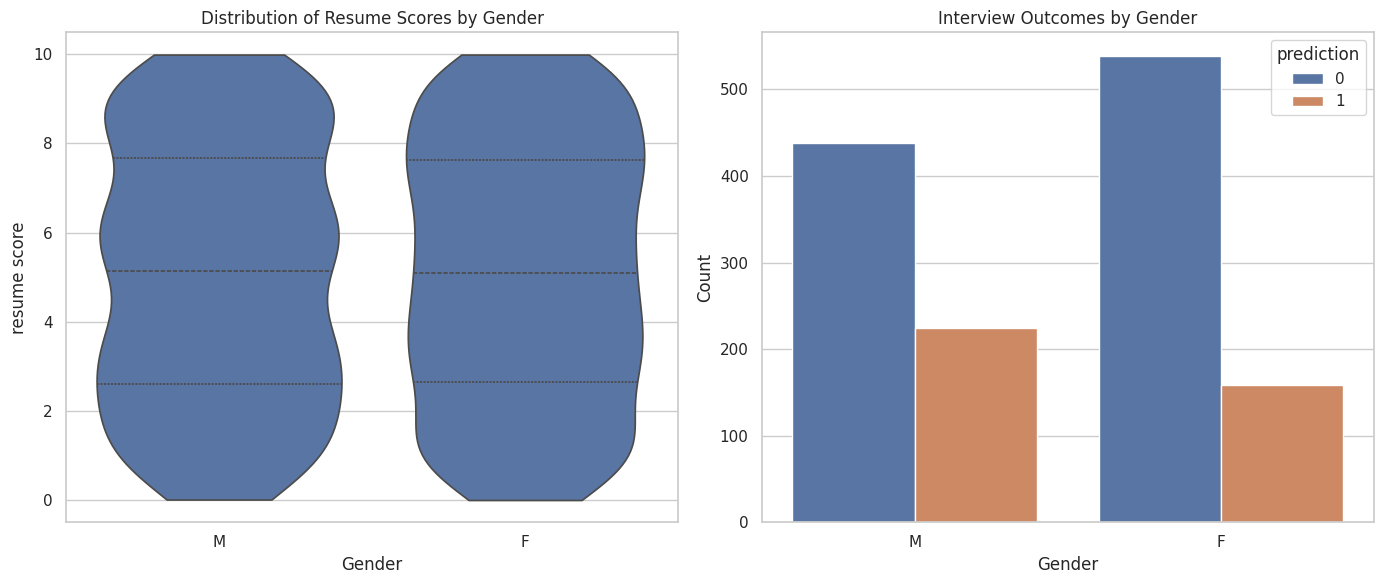

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Selection rates for interviews by Gender
selection_rate_gender = resume_scored_evaluated.groupby('Gender')['prediction'].mean()
print("Selection Rates by Gender:")
print(selection_rate_gender)

# 2. Graphs: distribution of resume scores and predictions by gender

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Histogram of Resume Scores by Gender
sns.violinplot(data=resume_scored_evaluated, x='Gender', y='Resume score', ax=ax[0], inner='quartile', cut=0)
ax[0].set_title('Distribution of Resume Scores by Gender')
ax[0].set_xlabel('Gender')
ax[0].set_ylabel('resume score')

# Bar Plot of Interview Outcomes by Gender
sns.countplot(data=resume_scored_evaluated, x='Gender', hue='prediction', ax=ax[1])
ax[1].set_title('Interview Outcomes by Gender')
ax[1].set_xlabel('Gender')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [7]:
# See the
gender_filtered = resume_scored_evaluated[resume_scored_evaluated['Gender'].isin(['M', 'F'])]
gender_filtered['Gender'] = gender_filtered['Gender'].astype('category')

formula = 'prediction ~ Q("Resume score") * C(Gender)'

model = smf.logit(formula=formula, data=gender_filtered).fit()

model.summary()

<ipython-input-7-64e22db4b0a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_filtered['Gender'] = gender_filtered['Gender'].astype('category')


Optimization terminated successfully.
         Current function value: 0.584828
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             prediction   No. Observations:                 1360
Model:                          Logit   Df Residuals:                     1356
Method:                           MLE   Df Model:                            3
Date:                Mon, 06 May 2024   Pseudo R-squ.:                 0.01623
Time:                        22:00:43   Log-Likelihood:                -795.37
converged:                       True   LL-Null:                       -808.49
Covariance Type:            nonrobust   LLR p-value:                 8.497e-06
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.3706      0.185     -7.390      0.000      -1.734      -1.007
C(Gender)[T.M]                       0.3800      0.252      1.507      0.132      -0.114       0.874
Q("Resume score")                    0.0291      0.031      0.937      0.349      -0.032       0.090
Q("Resume score"):C(Gender)[T.M]     0.0329      0.042      0.781      0.435      -0.050       0.116
====================================================================================================
"""

## Evaluation in 3 Baisc Independence, Separation, Sufficiency

In [ ]:
# Data Splitting

yhat_example       = resume_scored_evaluated.iloc[:, -1].tolist()
y_test_example     = 
group_test_example = resume_scored_evaluated['gender'].tolist()


In [ ]:
def independence(y_hat, group):
  """
  Computes an independence metric between two specific groups.

  Args:
    y_hat (np.ndarray): Classifier predictions.
    group (np.ndarray): Array of indices corresponding to group membership.
      For this assignment, we will focus on comparing groups 1 and 2.
      These correspond to the 'White alone' and 'Black or African American'
      groups. Note that one can also compare different combinations of groups.

  Returns:
    float: independence measure
  """
  # TODO: compute independence
  conditional_above=np.sum((y_hat==True)&(group==2))/np.sum(group==2)
  conditional_below=np.sum((y_hat==True)&(group==1))/np.sum(group==1)
  independence_metric=conditional_above/conditional_below
  return independence_metric




def separation(y_hat, y_true, group):
  """
  Computes a separation metric between two specific groups.

  Args:
    y_hat  (np.ndarray): Classifier predictions.
    y_true (np.ndarray): Data labels.
    group  (np.ndarray): Array of indices corresponding to group membership.
      For this assignment, we will focus on comparing groups 1 and 2.
      These correspond to the 'White alone' and 'Black or African American'
      groups. Note that one can also compare different combinations of groups.

  Returns:
    float: separation true positive
    float: separation false positive
  """
  # TODO: compute separation
  separation_true_above=np.sum((y_hat==True)&(y_true==True)&(group==2))/np.sum((y_true==True)&(group==2))
  separation_true_below=np.sum((y_hat==True)&(y_true==True)&(group==1))/np.sum((y_true==True)&(group==1))
  separation_true=separation_true_above/separation_true_below
  separation_false_above=np.sum((y_hat==True)&(y_true==False)&(group==2))/np.sum((y_true==False)&(group==2))
  separation_false_below=np.sum((y_hat==True)&(y_true==False)&(group==1))/np.sum((y_true==False)&(group==1))
  separation_false=separation_false_above/separation_false_below
  return separation_true,separation_false




def sufficiency(y_hat, y_true, group):
  """
  Computes a sufficiency metric between two specific groups.

  Args:
    y_hat  (np.ndarray): Classifier predictions.
    y_true (np.ndarray): Data labels.
    group  (np.ndarray): Array of indices corresponding to group membership.
      For this assignment, we will focus on comparing groups 1 and 2.
      These correspond to the 'White alone' and 'Black or African American'
      groups. Note that one can also compare different combinations of groups.

  Returns:
    float: sufficiency metric
  """
  # TODO: compute sufficiency
  sufficiency_above=np.sum((y_true==True)&(y_hat==True)&(group==2))/np.sum((y_hat==True)&(group==2))
  sufficiency_below=np.sum((y_true==True)&(y_hat==True)&(group==1))/np.sum((y_hat==True)&(group==1))
  sufficiency=sufficiency_above/sufficiency_below
  return sufficiency


def eval(yhat, y_test, group_test, model_title):
  print("Results from the " + model_title + " model: ")
  print("the indepence of prediction and group is ", independence(yhat, group_test))
  true_s, false_s = separation(yhat, y_test, group_test)
  print("the true positive separation is ", true_s)
  print("the false positive separation is ", false_s)
  print("the sufficiency of the prediction and the group is", sufficiency(yhat, y_test, group_test))

## SPD, DI,EOD, AAOD evaluation 

In [ ]:
def spd(sensitive_attribute, dataset, predicted_labels, majority_class, minority_class):
    """
    Calculate the Statistical Parity Difference (SPD) between majority and minority classes based on predicted labels.

    Parameters:
    - sensitive_attribute (str): Name of the column representing the sensitive attribute.
    - dataset (pd.DataFrame): The dataset containing the sensitive attribute and true outcome variable.
    - predicted_labels (pd.Series): Predicted labels for the outcome variable.
    - majority_class: Value representing the majority class in the sensitive attribute.
    - minority_class: Value representing the minority class in the sensitive attribute.

    Returns:
    - spd (float): Statistical Parity Difference between majority and minority classes.
    """
    # TODO: Compute the spd value
    major_indic=dataset[sensitive_attribute]==majority_class
    minor_indic=dataset[sensitive_attribute]==minority_class
    p_left=np.sum((predicted_labels[minor_indic]==True))/np.sum(dataset[sensitive_attribute]==minority_class)
    p_right=np.sum((predicted_labels[major_indic]==True))/np.sum(dataset[sensitive_attribute]==majority_class)
    spd_val=p_left-p_right
    return spd_val



def di(sensitive_attribute, dataset, predicted_labels, majority_class, minority_class):
    """
    Calculate the Disparate Impact (DI) between majority and minority classes based on predicted labels.

    Parameters:
    - sensitive_attribute (str): Name of the column representing the sensitive attribute.
    - dataset (pd.DataFrame): The dataset containing the sensitive attribute and true outcome variable.
    - predicted_labels (pd.Series): Predicted labels for the outcome variable.
    - majority_class: Value representing the majority class in the sensitive attribute.
    - minority_class: Value representing the minority class in the sensitive attribute.

    Returns:
    - di (float): Disparate Impact between majority and minority classes.
    """
    # TODO: Compute the DI value
    major_indic=dataset[sensitive_attribute]==majority_class
    minor_indic=dataset[sensitive_attribute]==minority_class
    p_above=np.sum((predicted_labels[minor_indic]==True))/np.sum(dataset[sensitive_attribute]==minority_class)
    p_below=np.sum((predicted_labels[major_indic]==True))/np.sum(dataset[sensitive_attribute]==majority_class)
    di_val=p_above/p_below
    return di_val


from pickle import TRUE
def eod(sensitive_attribute, predictions, dataset, true_labels, majority_class, minority_class):
    """
    Calculate the Equal Opportunity Difference (EOD) measure.

    Parameters:
    - sensitive_attribute: The column name of the sensitive attribute in the dataset.
    - predictions: Predictions made by the model.
    - dataset: The dataset containing the sensitive attribute and the outcome variable.
    - outcome_variable: The column name of the outcome variable in the dataset.
    - majority_class: The majority class label.
    - minority_class: The minority class label.

    Returns:
    - eod_value: The Equal Opportunity Difference measure.
    """
    # TODO: Compute the eod value
    major_indic=dataset[sensitive_attribute]==majority_class
    minor_indic=dataset[sensitive_attribute]==minority_class
    p_left=np.sum((true_labels[minor_indic]==True)&(predictions[minor_indic]==True))/np.sum(true_labels[minor_indic]==True)
    p_right=np.sum((true_labels[major_indic]==True)&(predictions[major_indic]==True))/np.sum(true_labels[major_indic]==True)
    eod_value=p_left-p_right
    return eod_value





def aaod(sensitive_attribute, predictions, dataset, true_labels, majority_class, minority_class):
    """
    Calculate the Average Absolute Odds Difference (AAOD) to measure bias.

    Parameters:
    - sensitive_attribute (str): The name of the sensitive attribute in the dataset.
    - predictions (pd.Series): The predicted values.
    - dataset (pd.DataFrame): The dataset containing the sensitive attribute, predictions, and outcome variable.
    - outcome_variable (str): The name of the outcome variable in the dataset.
    - majority_class (int): The label of the majority class.
    - minority_class (int): The label of the minority class.

    Returns:
    - float: The calculated Average Absolute Odds Difference (AAOD).
    """
    # TODO: Compute the aaod value
    major_indic = dataset[sensitive_attribute] == majority_class
    minor_indic = dataset[sensitive_attribute] == minority_class
    tp_majority = np.sum((predictions[major_indic] == True) & (true_labels[major_indic] == True))
    fp_majority = np.sum((predictions[major_indic] == True) & (true_labels[major_indic] == False))
    tn_majority = np.sum((predictions[major_indic] == False) & (true_labels[major_indic] == False))
    fn_majority = np.sum((predictions[major_indic] == False) & (true_labels[major_indic] == True))
    tp_minority = np.sum((predictions[minor_indic] == True) & (true_labels[minor_indic] == True))
    fp_minority = np.sum((predictions[minor_indic] == True) & (true_labels[minor_indic] == False))
    tn_minority = np.sum((predictions[minor_indic] == False) & (true_labels[minor_indic] == False))
    fn_minority = np.sum((predictions[minor_indic] == False) & (true_labels[minor_indic] == True))
    fpr_minority=fp_minority/(fp_minority+tn_minority)
    tpr_minority=tp_minority/(tp_minority+fn_minority)
    fpr_majority=fp_majority/(fp_majority+tn_majority)
    tpr_majority=tp_majority/(tp_majority+fn_majority)
    aaod_value=0.5*(np.abs(fpr_minority-fpr_majority)+np.abs(tpr_minority-tpr_majority))
    return aaod_value



def compute_metrics(sensitive_attribute, predictions, dataset, true_labels, majority_class, minority_class, disp=True):
  metrics = {}

  # TODO: Fill out the metrics dictionary
  metrics['statistical parity difference']=spd(sensitive_attribute,dataset,predictions,majority_class,minority_class)
  metrics['disparate impact'] = di(sensitive_attribute,dataset,predictions,majority_class,minority_class)
  metrics['equal opportunity difference'] = eod(sensitive_attribute, predictions, dataset, true_labels, majority_class, minority_class)
  metrics['average absolute odds difference'] =aaod(sensitive_attribute, predictions, dataset, true_labels, majority_class, minority_class)

  if disp:
      for k in metrics:
          print("%s = %.4f" % (k, metrics[k]))

  return metrics